In [9]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import zipfile
import urllib.request

# Test import
print("All imports successful!")

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

All imports successful!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#Load the CSV files into DataFrames


# Load Data
folder_path = '/content/drive/MyDrive/Movie Review Dataset'
train_df = pd.read_csv(f'{folder_path}/train_movie_review.csv')
val_df = pd.read_csv(f'{folder_path}/val_movie_review.csv')
test_df = pd.read_csv(f'{folder_path}/test_movie_review.csv')



In [13]:
# Drop unnecessary index columns
for df in [train_df, val_df, test_df]:
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)


In [14]:
# Preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

contraction_mapping = {
    "don't": "do not",
    "can't": "cannot",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def expand_contractions(text):
    for contraction, expanded in contraction_mapping.items():
        text = re.sub(contraction, expanded, text)
    return text

def clean_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

train_df['cleaned_review'] = train_df['review'].apply(clean_text)
val_df['cleaned_review'] = val_df['review'].apply(clean_text)
test_df['cleaned_review'] = test_df['review'].apply(clean_text)


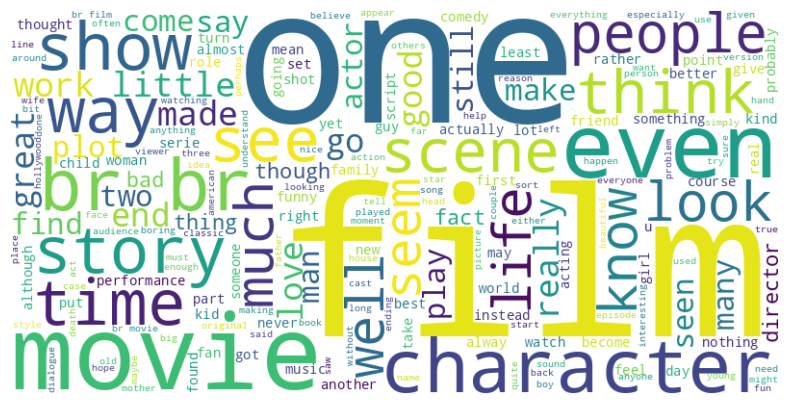

In [15]:
# Visualize Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(train_df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
# Tokenization and Padding
X_train = train_df['cleaned_review']
y_train = train_df['sentiment']
X_val = val_df['cleaned_review']
y_val = val_df['sentiment']
X_test = test_df['cleaned_review']
y_test = test_df['sentiment']

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = int(np.percentile([len(seq) for seq in X_train_seq], 95))
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.initializers import Constant

vocab_size = 10000
embedding_dim = 64

In [ ]:
# Model 1: Simple RNN
model1 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model 2: LSTM
model2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Download and unzip GloVe file directly in Colab
glove_zip_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"
glove_dir = "glove.6B"


In [ ]:
# Download the file
urllib.request.urlretrieve(glove_zip_url, glove_zip_path)

('glove.6B.zip', <http.client.HTTPMessage at 0x7d95ca758a10>)

In [ ]:
# Unzip the file
if not os.path.exists(glove_dir):
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)


In [ ]:
# Load the GloVe embeddings from the 100d file
def load_glove_embeddings(file_path, embedding_dim=100):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')
word2vec = load_glove_embeddings(glove_file, embedding_dim=100)

embedding_dim = 100  # Set to match the 100-dimensional GloVe model
vocab_size = min(10000, len(tokenizer.word_index) + 1)

embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with GloVe embeddings
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
        else:
            # Words not found get a random small vector or zeros (we use zeros here)
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [ ]:
# Model 3: LSTM + Gensim GloVe
model3 = Sequential([
    Embedding(vocab_size, embedding_dim,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=maxlen,
              trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model3.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

models = [model1, model2, model3]
histories = []

for i, model in enumerate(models):
    print(f"\nTraining Model {i+1}...")
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_val_pad, y_val), callbacks=[es], verbose=1)
    histories.append(history)

    # Evaluation
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



Training Model 1...
Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5193 - loss: 0.6860 - val_accuracy: 0.5138 - val_loss: 0.6957
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.5191 - loss: 0.6800 - val_accuracy: 0.5084 - val_loss: 0.7006
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.5204 - loss: 0.6741 - val_accuracy: 0.4920 - val_loss: 0.7012
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Accuracy: 0.5008
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.41      0.45      4961
           1       0.50      0.59      0.54      5039

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000


Training Model 2...
Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9604 - loss: 0.1203 - val_accuracy: 0.8728 - val_loss: 0.3559
Epoch 2/10
1094/1094

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


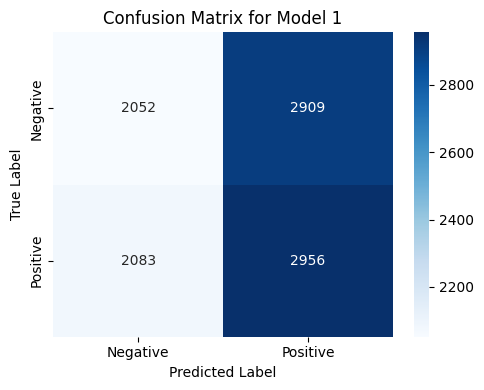

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


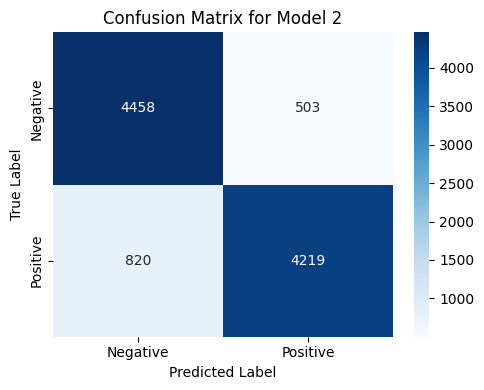

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


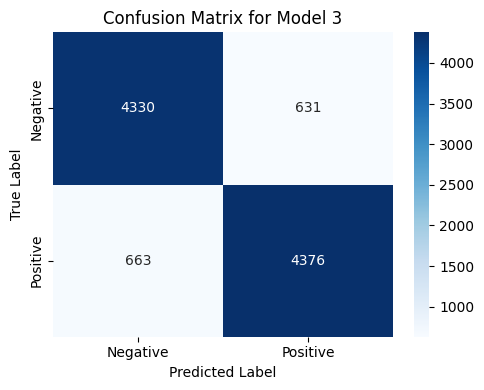

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Re-run predictions and plot confusion matrices for all models
for i, model in enumerate(models):
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for Model {i+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()



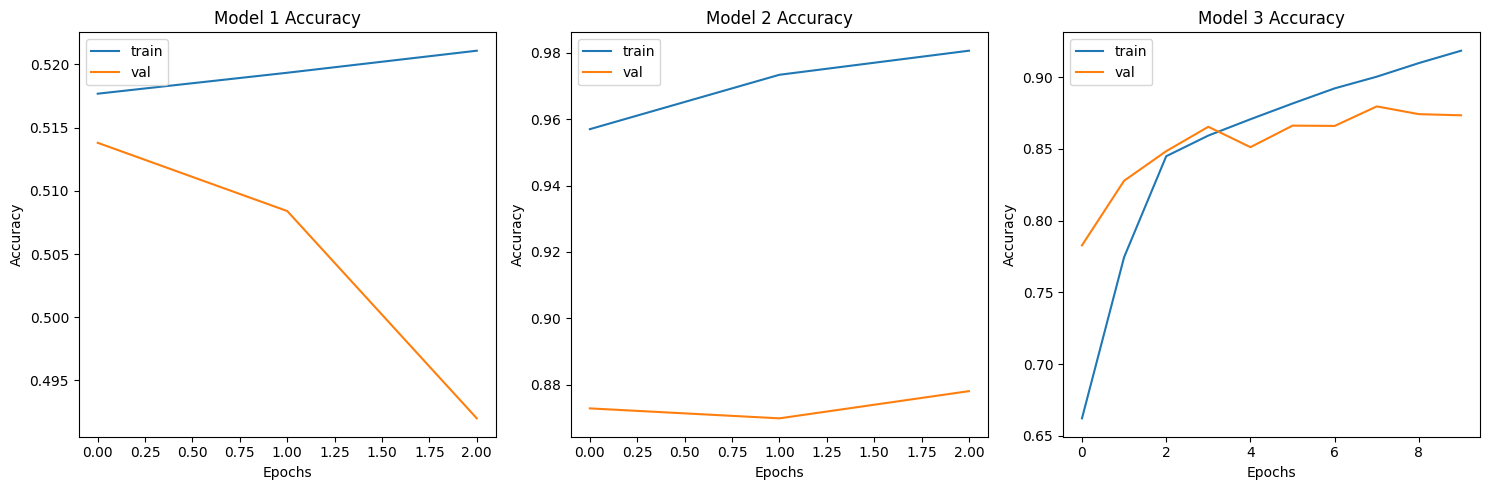

In [ ]:
# Visualization
plt.figure(figsize=(15, 5))
for i, history in enumerate(histories):
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'Model {i+1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model1.save("model1.keras")
model2.save("model2.keras")
model3.save("model3.keras")


In [17]:
!pip install gradio


In [18]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load models as they were saved
model1 = load_model("model1.keras")  # Simple RNN
model2 = load_model("model2.keras")  # LSTM
model3 = load_model("model3.keras")  # LSTM + Word2Vec

def predict_sentiment(text, model_name):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad_seq = pad_sequences(seq, maxlen=maxlen, padding='post')

    if model_name == "RNN":
        pred = model1.predict(pad_seq)[0][0]
    elif model_name == "LSTM":
        pred = model2.predict(pad_seq)[0][0]
    else:  # "LSTM + Word2Vec"
        pred = model3.predict(pad_seq)[0][0]

    label = "Positive" if pred > 0.5 else "Negative"
    return f"Model: {model_name} → {label} (Confidence: {pred:.2f})"

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=[
        gr.Textbox(lines=3, label="Enter review text here"),
        gr.Radio(choices=["RNN", "LSTM", "LSTM + Word2Vec"], value="LSTM + Word2Vec", label="Choose Model")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="IMDb Sentiment Classifier",
    description="Choose a model and input a review to see its predicted sentiment."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5b87b10c2e62297895.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
